### Summary
Summarizing the data we have the use of, we are given :    
*  a positive integer $n$ which is the number of dimension of the space. 
*  a positive integer $k$ which is the total number of discrete points we need to place inside that space.    
*  each continuous point $x$ queried in that space that follows a probability density function $PDF$.

And we are asked for:   
*  the $k$ discrete points that are placed in a way that minimizes the average distance (or mean error $ME$) from those continuous points $x$ .

# Proposed approach

We propose a method that:    
*   is an almost optimal solution that provides a decent decrease of the $ME$.
*   works for almost any number $k$ of points.
*   works for almost any number $n$ of dimensions.
*   adapts very fast (close to $\log k$ rate).
*   is always better than the $ME$ provided by a uniform discretization, even before it is adapted.
*   is "model" free. The $PDF$ of the appearance of $x$'s don't have to be known.

## How it works

The core idea behind this method is the $2^n$-trees. Like quadtrees and octrees with $n$ equal to 2 and 3 respectively, n-trees have any positive integer number $n$ as spatial subdivision factor, or also known as branching factor. $n$ describes the dimensions of the space that these trees spread. The $2^n$ child branches of each parent node, expand to all the basic directions in order to fill up all the space as uniform as possible. 

Each node is a point in space that covers a specified region. This region is the corresponding fraction of its parent's region. In other words, the parent splits the region that is assigned to it to $2^n$ equal sub-regions with volume $\frac{1}{2^n}$ times smaller than their parent's. The sub-regions that are produced are n-dimensional cubes too and have no overlapping except their touching surfaces. Of coarse they fully overlap with their parent because they are actually its sub-set. As the height of the tree is growing, the nodes that are created have smaller and smaller volumes. Each point is located in the middle of the cube so there will be no way for two or more points to be in the same location. So a tree with $k$ nodes will have $k$ different points inside the given space.

We assign to the root node the whole space we want to use, in our case the unit cube between the points $[0, 0, ..., 0]$ and $[1, 1, ..., 1]$. For example, lets take $n=2$. Root, the node in level zero, will have the point $[0.5,0.5]$ and determined by the vertices $[0,0],[1,1]$. Its $2^n=4$ branches, will split this area in 4 equal 2d-cubes (aka rectangles) with vertices and points:   
*   cube 1 -> vertices $[0,0],[0.5,0.5]$ , point $[0.25,0.25]$  
*   cube 2 -> vertices $[0.5,0],[1,0.5]$ , point $[0.75,0.25]$  
*   cube 3 -> vertices $[0,0.5],[0.5,1]$ , point $[0.25,0.75]$  
*   cube 4 -> vertices $[0.5,0.5],[1,1]$ , point $[0.75,0.75]$     

So now we have 5 points to fill up this space. Those 4 branches can be extended to create 16 new sub-branches (4 more branches each) adding to a total of 21 points.

Additionally, nodes keep some useful informations that help **evaluate** them. It's very important to know what _ME_ each node produces and what it would have produced if it wasn't there. When user queries a point $x$, we find the corresponding node by starting from root and recursively finding all the sub-branches until that one leaf, that is responsible for the region that this point belongs. This search will not necessarily give us the nearest point to $x$, but it is very useful for two other things.
*    First of all, the result may not be the nearest point, but it will be the node that is __responsible for this specific area__. This means that if we want to increase the resolution of points, near that particular $x$ we have to expand the node that will be returned from that search. Using our previous example, for $x=[0.4, 0.4]$ the result of the search will be the node with the point $[0.25, 0.25]$ even if root's point $[0.5, 0.5]$ is closer. But expanding this node will create a branch with point $[0.375, 0.375]$.    
*   The second benefit is that while doing this search, __we can easily collect the information we need for the evaluation__, like the distance from the responsible point and the distance from its parent's point. Using again our previous example, searching for $[0.4, 0,4]$ will traverse root and its branch with the point $[0.25, 0.25]$. In the process we can find the Euclidean distance of $x$ to each node point, which is $0.141421$ and $0.212132$ respectively. This gives us useful information about each node's utility.


## Adaption of the tree
We said before that the points of the nodes are have fixed locations, which make the unable to move and adapt by themselves. __By creating and deleting points we try to match the right set of points that match the PDF the most__. So the adaption is actually a fitting. And we have all the required components to do that. We can expand and prune nodes to increase and decrease resolution and we have a way of evaluating them to choose what is the best for each one of them.

### Increase resolution
In order to decrease $ME$ we need to increase the resolution of points in regions that is needed. Obviously, the way to increase resolution in the desired regions is to expand the corresponding nodes. But there are two types of nodes. The expandable ones, that have unexpanded sub-branches, and the not expandable that are already fully expanded.    

To expand an expandable node we just create all its sub-branches. New points are spread to all directions trying to fill up uniformly the space around the parent point. The goal is actually to search this region for a place of interest. Points that fall into this place will marked as useful by the evaluation process and will "survive" as the other will be deleted in the next update.

Expanding a non-expandable node is trickier than expanding an expandable one. As we said before, this node is already fully expanded. But if our evaluation system says that we need to do that, we can't ignore it. Fully expand its closest expandable children would be a solution but it will create too many useless new nodes. We need a more targeted expansion. We can partly expand all the $2^n$ expandable nodes that are closest to the this node. By partly i mean only the node that is towards the desired point.

To generalize into a more compact solution, we create  all the nodes that will approach the point we want independently of the current state of the corresponding node. This means that direct (if there are any) and more distant sub-branches will be created. So expansion always creates $2^n$ new nodes, but not necessary in the same levels. 


### Decrease resolution
Decreasing resolution almost any time increases $ME$ but is necessary to maintain the right number of points. It is done by simply deleting/cutting a leaf node from its parent. Because leaf nodes have no sub-branches, the total number of points is decreased by 1. By cutting each node we don't need we free space for other nodes to be expanded.

### Decide which node to expand and which to cut
Our goal is to decrease the $ME$ as much as possible to get as close as possible to the optimal solution. But as we said before, each node is a point which means that their position is fixed in the space. They can't be moved to any direction, only to get expanded or cut. So the best we can do is to choose the set of points that provide the minimum $ME$. Also, because the PDF of the $x$'s is not known, we can't predict the amount that the $ME$ will decreased or increased after a cut or and expansion. We just have to try, and this is not so straightforward. We must cut nodes with low values to make space for expansion of nodes with very high values. But looking only the value of each point is not the right way to do this. Some nodes don't participate directly on the decrease of $ME$ but they are base for a whole sub-tree that does. Other nodes have very low values not because the are useless, but because the minimized the distance in a region, and cutting them will actually increase the $ME$.



In [3]:
#!/usr/bin/python3
import sys
sys.path.insert(0, '../src/')

from ntree import *
from tree_vis import *

import numpy as np
import matplotlib.pyplot as plt

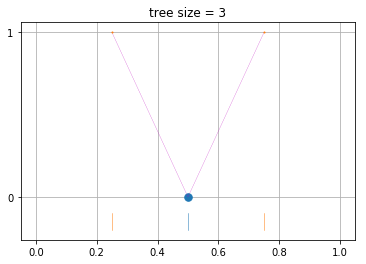

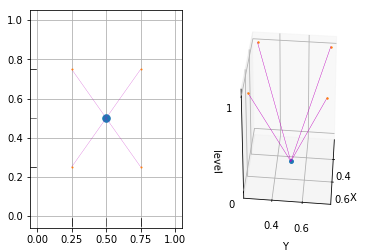

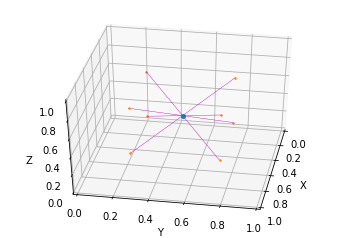

In [4]:
# One parent node and its 2^n childs for n=1,2,3
tree = Tree(1, 3)
tree.plot()
tree = Tree(2, 5)
tree.plot()
tree = Tree(3, 9)
tree.plot()